In [1]:
#Imports
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import seaborn as sns

In [ ]:
# Téléchargement des ressources NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Spécifie le chemin vers ton dossier nltk_data local
nltk.data.path.append('/Users/r1/Desktop/Classification commentaires positifs et négatifs mémoire/nltk_data')

# Initialisation des outils
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


# **Etape 1**: Prétraitement et chargement des données

In [ ]:
#Première version à garder au cas où
# Nettoyage du texte
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Suppression des stopwords
def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()
    return ' '.join([word for word in tokens if word not in stop_words])

# Charger les données
df = pd.read_csv('/Users/r1/Desktop/Classification commentaires positifs et négatifs mémoire/IMDB Dataset.csv', nrows=5000)
df['processed_review'] = df['review'].apply(preprocess_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})



In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

#Chemin vers tes ressources nltk locales
nltk.data.path.append('/Users/r1/Desktop/Classification commentaires positifs et négatifs mémoire/nltk_data')

#Initialisation
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#  Fonction pour mapper les POS Treebank → WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Par défaut : nom

#  Fonction de nettoyage brut
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#  Fonction complète : nettoyage + tokenisation + POS + lemmatisation + stopwords
def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)

    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged_tokens
        if word not in stop_words
    ]
    return ' '.join(lemmatized)


In [ ]:
print(preprocess_text("The cats are running around the house, jumping and having fun!"))
# Résultat attendu : "cat run house jump fun"

cat run around house jumping fun


In [ ]:
#  Chargement du dataset + application du prétraitement
df = pd.read_csv('/Users/r1/Desktop/Classification commentaires positifs et négatifs mémoire/IMDB Dataset.csv', nrows=10000)
df['processed_review'] = df['review'].apply(preprocess_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# **Étape 2** : Vectorisation

In [6]:
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_review']).toarray()
y = df['label'].values

## Préparation à l'étape 3: Choix du nombre de composantes principales à prendre pour le kernel pca et le choix du noyau

In [6]:
#Code pour vérifier la PSD de la matrice noyau centrée ( parce que le noyau peut prendre des valeurs négatives)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from numpy.linalg import eigvalsh  # valeurs propres symétriques

# Prétraitement et vectorisation
vectorizer = CountVectorizer(max_features=5000)
X_counts = vectorizer.fit_transform(df['processed_review'])
X_dense = X_counts.toarray()

# Matrice de similarité cosinus (i.e. noyau cosinus)
K = cosine_similarity(X_dense)

# Centrage de la matrice noyau (comme dans Kernel PCA)
N = K.shape[0]
one_n = np.ones((N, N)) / N
K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

# Valeurs propres
eigenvalues = eigvalsh(K_centered)

# Affichage
print("Valeurs propres (extraites) :", eigenvalues[:10])
print("Valeur propre minimale :", np.min(eigenvalues))

# Vérification PSD
if np.all(eigenvalues >= -1e-8):
    print(" La matrice noyau centrée est semi-définie positive (PSD)")
else:
    print(" La matrice noyau centrée contient des valeurs propres négatives significatives")


Valeurs propres (extraites) : [-5.74986242e-16  7.37924297e-17  2.36673894e-16  1.02293486e-15
  1.95788121e-13  9.00242915e-08  1.89709231e-07  3.68007640e-07
  6.03716729e-07  7.27155231e-07]
Valeur propre minimale : -5.749862419510248e-16
 La matrice noyau centrée est semi-définie positive (PSD)


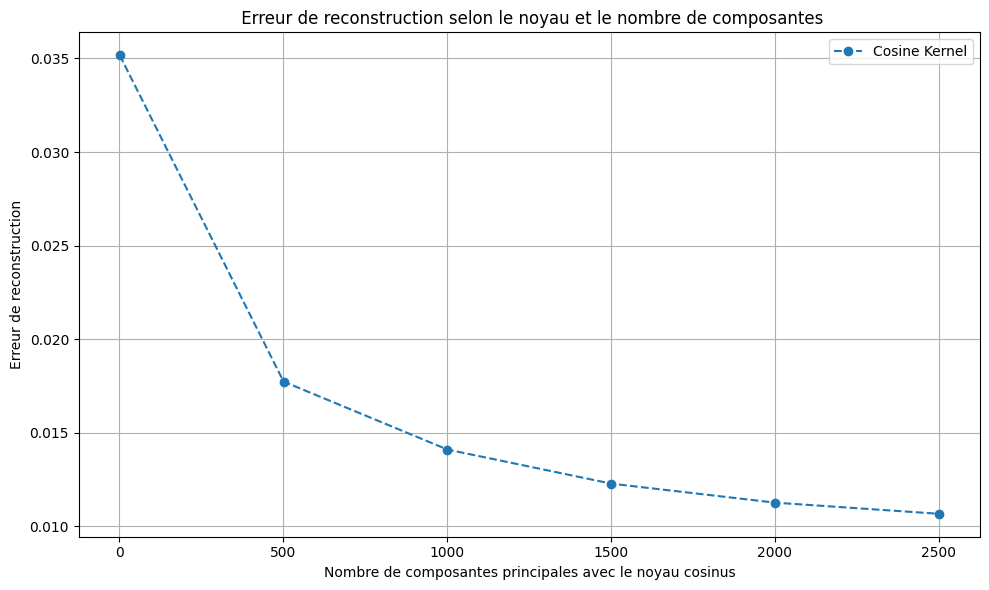

In [20]:
# Test des noyaux et des dimensions
#noyaux = ["rbf", "poly", "cosine", "linear"]

n_composantes_test = list(range(1, 3000, 500))  
plt.figure(figsize=(10, 6))
reconstruction_errors = []
    
for n in n_composantes_test:
    kpca = KernelPCA(n_components=n, kernel="cosine", fit_inverse_transform=True, gamma=0.01)
    X_kpca = kpca.fit_transform(X)
    X_reconstructed = kpca.inverse_transform(X_kpca)
        
    # Calcul de l'erreur de reconstruction
    error = np.mean((X - X_reconstructed) ** 2)
    reconstruction_errors.append(error)
    
# Tracé de la courbe pour ce noyau
plt.plot(n_composantes_test, reconstruction_errors, marker='o', linestyle='--', label="Cosine Kernel")


# Affichage du graphique
plt.xlabel("Nombre de composantes principales avec le noyau cosinus")
plt.ylabel("Erreur de reconstruction")
plt.title(" Erreur de reconstruction selon le noyau et le nombre de composantes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


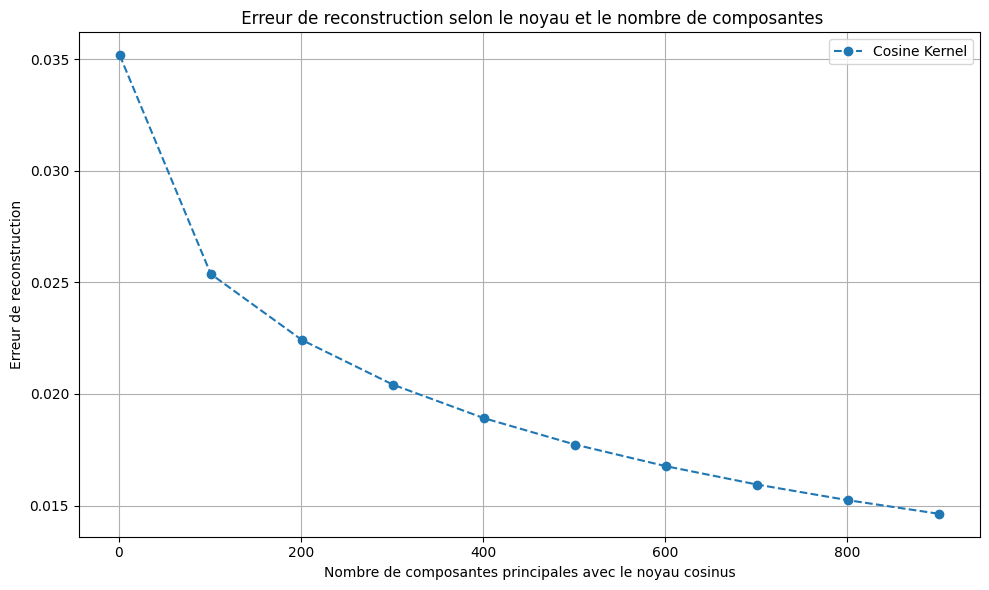

In [21]:
# Test des noyaux et des dimensions

n_composantes_test = list(range(1, 1000, 100))  
plt.figure(figsize=(10, 6))
reconstruction_errors = []
    
for n in n_composantes_test:
    kpca = KernelPCA(n_components=n, kernel="cosine", fit_inverse_transform=True, gamma=0.01)
    X_kpca = kpca.fit_transform(X)
    X_reconstructed = kpca.inverse_transform(X_kpca)
        
    # Calcul de l'erreur de reconstruction
    error = np.mean((X - X_reconstructed) ** 2)
    reconstruction_errors.append(error)
    
# Tracé de la courbe pour ce noyau
plt.plot(n_composantes_test, reconstruction_errors, marker='o', linestyle='--', label="Cosine Kernel")


# Affichage du graphique
plt.xlabel("Nombre de composantes principales avec le noyau cosinus")
plt.ylabel("Erreur de reconstruction")
plt.title(" Erreur de reconstruction selon le noyau et le nombre de composantes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


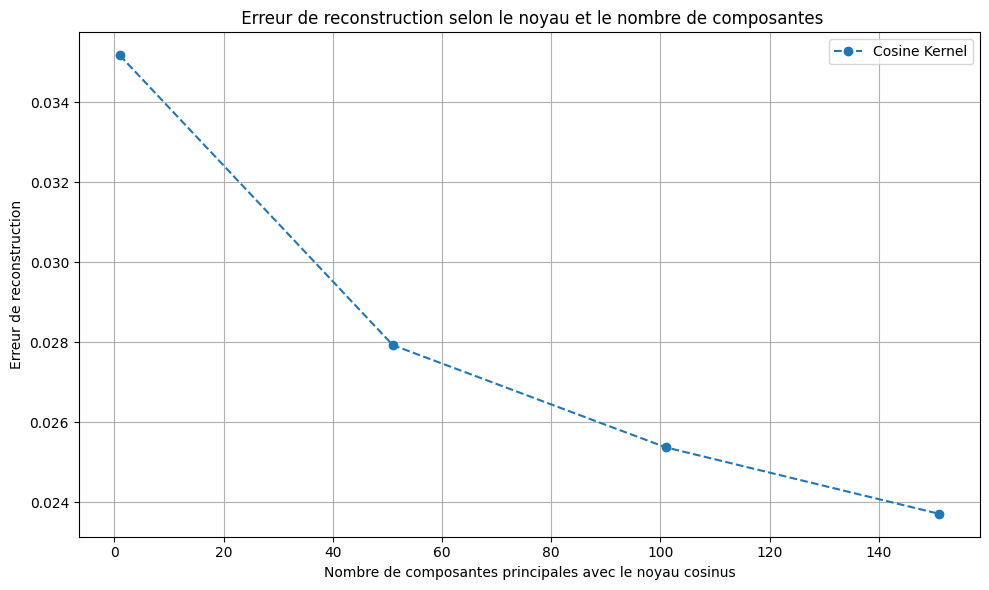

In [27]:
# Test des noyaux et des dimensions

n_composantes_test = list(range(1, 200, 50))  
plt.figure(figsize=(10, 6))
reconstruction_errors = []
    
for n in n_composantes_test:
    kpca = KernelPCA(n_components=n, kernel="cosine", fit_inverse_transform=True, gamma=0.01)
    X_kpca = kpca.fit_transform(X)
    X_reconstructed = kpca.inverse_transform(X_kpca)
        
    # Calcul de l'erreur de reconstruction
    error = np.mean((X - X_reconstructed) ** 2)
    reconstruction_errors.append(error)
    
# Tracé de la courbe pour ce noyau
plt.plot(n_composantes_test, reconstruction_errors, marker='o', linestyle='--', label="Cosine Kernel")


# Affichage du graphique
plt.xlabel("Nombre de composantes principales avec le noyau cosinus")
plt.ylabel("Erreur de reconstruction")
plt.title(" Erreur de reconstruction selon le noyau et le nombre de composantes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

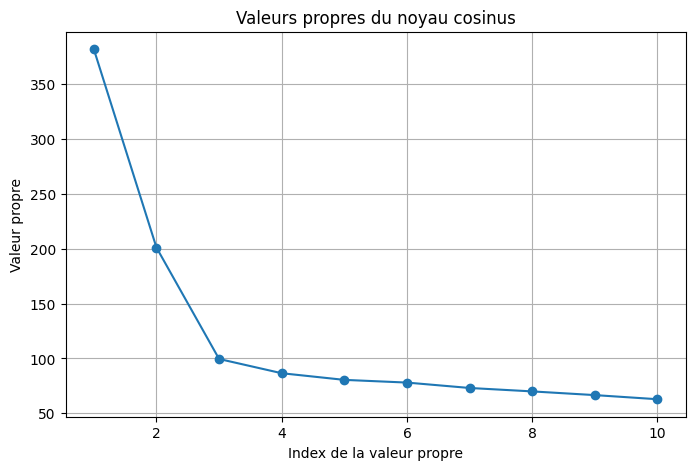

In [26]:
eigenvalues = kpca.eigenvalues_[:10]  
plt.figure(figsize=(8, 5))
plt.plot(range(1,11), eigenvalues, marker='o', linestyle='-')
plt.title("Valeurs propres du noyau cosinus")
plt.xlabel("Index de la valeur propre")
plt.ylabel("Valeur propre")
plt.grid(True)
plt.show()

n_components = 20 --> F1-score moyen = 0.7366
n_components = 50 --> F1-score moyen = 0.7719
n_components = 70 --> F1-score moyen = 0.7888
n_components = 80 --> F1-score moyen = 0.7894
n_components = 90 --> F1-score moyen = 0.7864
n_components = 100 --> F1-score moyen = 0.7930
n_components = 110 --> F1-score moyen = 0.7916
n_components = 120 --> F1-score moyen = 0.7903
n_components = 130 --> F1-score moyen = 0.7975
n_components = 140 --> F1-score moyen = 0.7919
n_components = 150 --> F1-score moyen = 0.7955
n_components = 200 --> F1-score moyen = 0.7955
n_components = 250 --> F1-score moyen = 0.7993
n_components = 300 --> F1-score moyen = 0.8020
n_components = 500 --> F1-score moyen = 0.7947
n_components = 1000 --> F1-score moyen = 0.7967


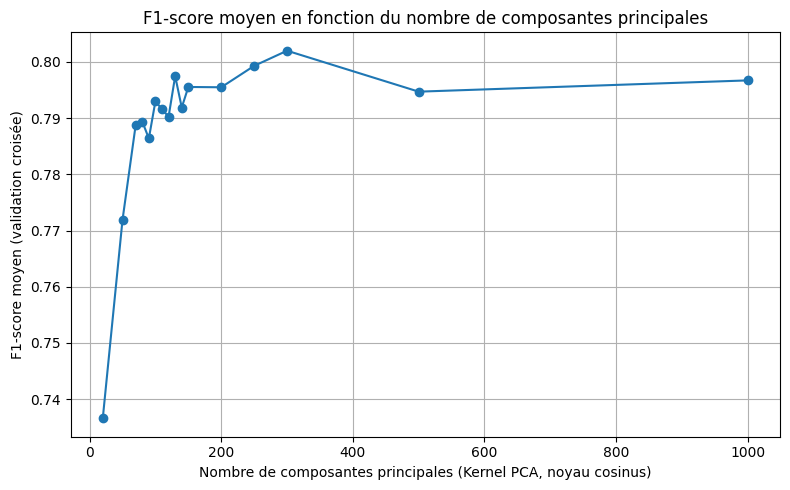

In [11]:
#Grid search pour le meilleur nombre de composantes principales
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# Sous-échantillonnage rapide (par exemple 1000 exemples)
X_sample = X[:1000] if hasattr(X, 'shape') and X.shape[0] > 1000 else X
y_sample = y[:1000] if len(y) > 1000 else y

# Liste des composantes à tester
n_components_list = [20,50,70,80,90,100, 110, 120, 130, 140, 150, 200, 250, 300, 500, 1000]

# Pour stocker les F1-scores
f1_scores = []

# Boucle sur les différents n_components
for n in n_components_list:
    kpca = KernelPCA(n_components=n, kernel='cosine', random_state=42)
    X_kpca = kpca.fit_transform(X_sample)

    # Modèle : Logistic Regression
    model = LogisticRegression(max_iter=1000, random_state=42)

    # Validation croisée : moyenne des F1-scores
    scores = cross_val_score(model, X_kpca, y_sample, cv=3, scoring='f1')
    mean_f1 = np.mean(scores)
    f1_scores.append(mean_f1)

    print(f"n_components = {n} --> F1-score moyen = {mean_f1:.4f}")

# Tracé du résultat
plt.figure(figsize=(8, 5))
plt.plot(n_components_list, f1_scores, marker='o', linestyle='-')
plt.title("F1-score moyen en fonction du nombre de composantes principales")
plt.xlabel("Nombre de composantes principales (Kernel PCA, noyau cosinus)")
plt.ylabel("F1-score moyen (validation croisée)")
plt.grid(True)
plt.tight_layout()
plt.show()


# **Étape 3** : Réduction de dimension (Kernel PCA)

In [28]:
#Application du Kernel PCA avec le meilleur nombre de composantes que l'on a déterminé
kpca = KernelPCA(n_components=1000,kernel='cosine')
X_kpca = kpca.fit_transform(X)

# **Étape 4** : Création des modèles


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_kpca_train, X_kpca_test, y_kpca_train, y_kpca_test = train_test_split(X_kpca, y, test_size=0.3, random_state=42)

# 1. KNN sans Kernel PCA
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# 2. KNN avec Kernel PCA
knn_kpca = KNeighborsClassifier(n_neighbors=5)
knn_kpca.fit(X_kpca_train, y_kpca_train)
y_pred_knn_kpca = knn_kpca.predict(X_kpca_test)

# -----------------------------------
# 3. Logistic Regression sans Kernel PCA
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# 4. Logistic Regression avec Kernel PCA
logreg_kpca = LogisticRegression(max_iter=1000)
logreg_kpca.fit(X_kpca_train, y_kpca_train)
y_pred_logreg_kpca = logreg_kpca.predict(X_kpca_test)


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# -----------------------------------
# 7. SVM (linéaire) sans Kernel PCA
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# 8. SVM (linéaire) avec Kernel PCA
svm_kpca = SVC(kernel='rbf')
svm_kpca.fit(X_kpca_train, y_kpca_train)
y_pred_svm_kpca = svm_kpca.predict(X_kpca_test)




In [ ]:
# 15. SVM avec noyau cosinus (sans Kernel PCA)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC

# Train/Test split (tu peux réutiliser X_train, X_test déjà créés)
K_train = cosine_similarity(X_train)
K_test = cosine_similarity(X_test, X_train)

# SVM avec noyau pré-calculé (cosine)
svm_cosine = SVC(kernel='precomputed')
svm_cosine.fit(K_train, y_train)
y_pred_svm_cosine = svm_cosine.predict(K_test)

# Matrice noyau cosinus sur données réduites (post-Kernel PCA)
K_train_kpca = cosine_similarity(X_kpca_train)
K_test_kpca = cosine_similarity(X_kpca_test, X_kpca_train)

# SVM avec noyau cosinus
svm_cosine_kpca = SVC(kernel='precomputed')
svm_cosine_kpca.fit(K_train_kpca, y_kpca_train)
y_pred_svm_cosine_kpca = svm_cosine_kpca.predict(K_test_kpca)

# Évaluation
acc_cosine_kpca = accuracy_score(y_kpca_test, y_pred_svm_cosine_kpca)
f1_cosine_kpca = f1_score(y_kpca_test, y_pred_svm_cosine_kpca)

acc_cosine_kpca, f1_cosine_kpca

#La plus value est pas ouf 



(0.8536666666666667, 0.8581583198707593)

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier


# -----------------------------------
# 9. Random Forest sans Kernel PCA
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


# 10. Random Forest sans Kernel PCA
rf_kpca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_kpca.fit(X_kpca_train, y_kpca_train)
y_pred_rf_kpca = rf_kpca.predict(X_kpca_test)

# -----------------------------------
# 11. MLP (réseau de neurones dense) sans Kernel PCA
mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# 12. MLP avec Kernel PCA
mlp_kpca = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)
mlp_kpca.fit(X_kpca_train, y_kpca_train)
y_pred_mlp_kpca = mlp_kpca.predict(X_kpca_test)

# -----------------------------------
# 13. Gradient Boosting sans Kernel PCA
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

# 14. Gradient Boosting avec Kernel PCA
gb_kpca = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_kpca.fit(X_kpca_train, y_kpca_train)
y_pred_gb_kpca = gb_kpca.predict(X_kpca_test)


In [ ]:

from sklearn.naive_bayes import MultinomialNB

# 5. Naive Bayes (MultinomialNB) sans Kernel PCA
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# 6. Naive Bayes (MultinomialNB) avec Kernel PCA
nb_kcpa = MultinomialNB()
nb_kcpa.fit(X_kpca_train, y_kpca_train)
y_pred_nb_kpca = nb.predict(X_kpca_test)

# Marche pas car avec le kernel pca on a des valeurs négatives


# **Étape 5** : Évaluation des performances



In [ ]:
results = []

def add_result(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    results.append({'Modèle': name, 'Accuracy': acc, 'F1-score': f1})

add_result("KNN (sans PCA)", y_test, y_pred_knn)
add_result("KNN (avec PCA)", y_kpca_test, y_pred_knn_kpca)
add_result("LogReg (sans PCA)", y_test, y_pred_logreg)
add_result("LogReg (avec PCA)", y_kpca_test, y_pred_logreg_kpca)

#add_result("Naive Bayes(sans PCA)", y_test, y_pred_nb)
#add_result("Naive Bayes (avec PCA)", y_kpca_test, y_pred_nb_kpca)  
add_result("SVM (rbf sans PCA)", y_test, y_pred_svm)
add_result("SVM (rbf avec PCA)", y_kpca_test, y_pred_svm_kpca)
#add_result("Random Forest(sans PCA)", y_test, y_pred_rf)
#add_result("Random Forest (avec PCA)", y_kpca_test, y_pred_rf_kpca)


#add_result("MLP (sans PCA)", y_test, y_pred_mlp)
#add_result("MLP (avec PCA)", y_kpca_test, y_pred_mlp_kpca)
#add_result("Gradient Boosting (sans PCA)", y_test, y_pred_gb)
#add_result("Gradient Boosting (avec PCA)", y_kpca_test, y_pred_gb_kpca)

add_result("SVM (cosine sans PCA)", y_test, y_pred_svm_cosine)
add_result("SVM (cosine avec PCA)", y_kpca_test, y_pred_svm_kpca)





# **Étape 6** : Affichage des résultats



 Résultats comparatifs avec noyau cosine:
               Modèle  Accuracy  F1-score
0      KNN (sans PCA)  0.629333  0.674282
1      KNN (avec PCA)  0.675333  0.690401
2   LogReg (sans PCA)  0.832000  0.834971
3   LogReg (avec PCA)  0.851000  0.855387
4  SVM (rbf sans PCA)  0.850667  0.857958
5  SVM (rbf avec PCA)  0.855000  0.859903


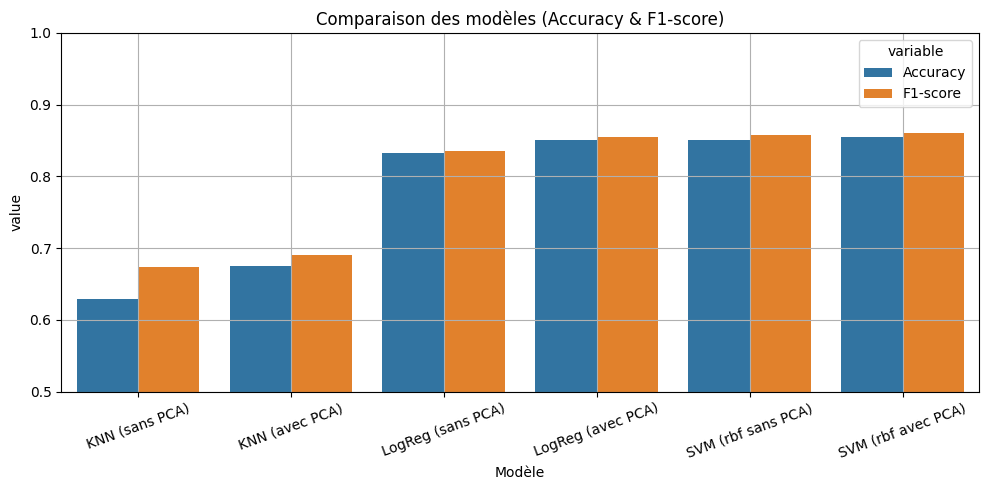

In [31]:
df_results = pd.DataFrame(results)
print("\n Résultats comparatifs avec noyau cosine:")
print(df_results)

# Barplot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results.melt(id_vars="Modèle"), x="Modèle", y="value", hue="variable")
plt.title("Comparaison des modèles (Accuracy & F1-score)")
plt.ylim(0.5, 1)
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()

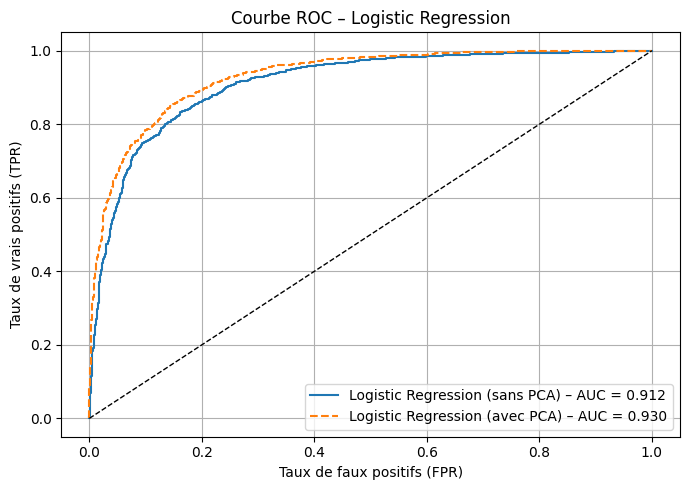

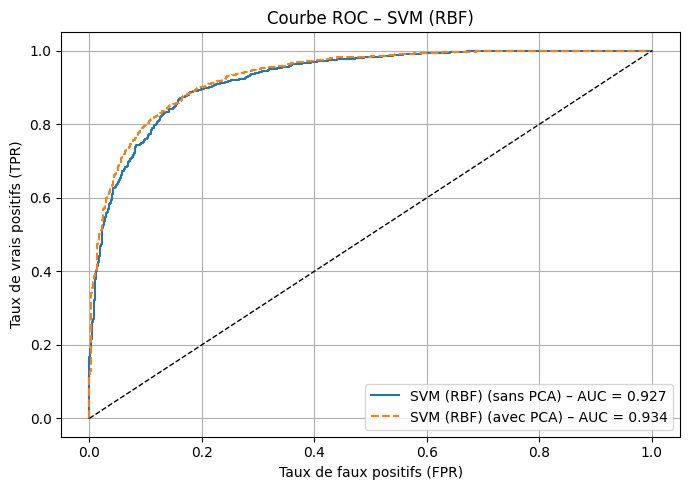

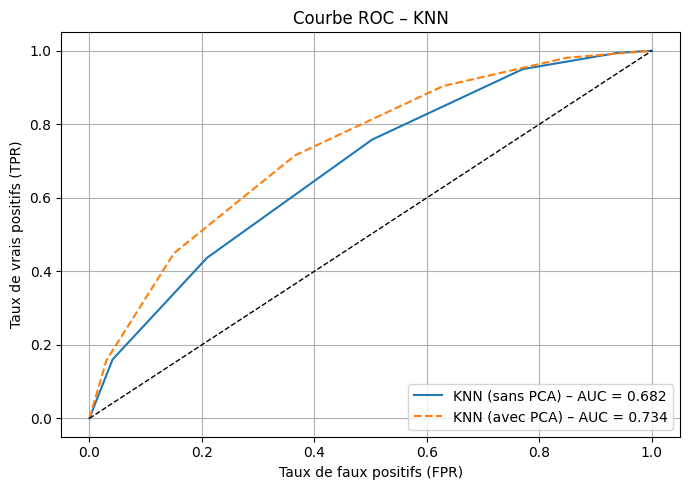

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Dictionnaire avec modèles sans et avec Kernel PCA
models_comparaison = {
    "Logistic Regression": (logreg, X_test, logreg_kpca, X_kpca_test),
    "SVM (RBF)": (svm, X_test, svm_kpca, X_kpca_test),
    "KNN": (knn, X_test, knn_kpca, X_kpca_test),
    #"Random Forest": (rf, X_test, rf_kpca, X_kpca_test),
    #"MLP": (mlp, X_test, mlp_kpca, X_kpca_test),
    #"Gradient Boosting": (gb, X_test, gb_kpca, X_kpca_test),
}

for name, (model_no_pca, X_eval_no_pca, model_pca, X_eval_pca) in models_comparaison.items():
    plt.figure(figsize=(7, 5))

    # --- Sans Kernel PCA ---
    if hasattr(model_no_pca, "predict_proba"):
        y_score_no_pca = model_no_pca.predict_proba(X_eval_no_pca)[:, 1]
    elif hasattr(model_no_pca, "decision_function"):
        y_score_no_pca = model_no_pca.decision_function(X_eval_no_pca)
    else:
        continue

    fpr_no_pca, tpr_no_pca, _ = roc_curve(y_test, y_score_no_pca)
    auc_no_pca = auc(fpr_no_pca, tpr_no_pca)
    plt.plot(fpr_no_pca, tpr_no_pca, label=f"{name} (sans PCA) – AUC = {auc_no_pca:.3f}", linestyle='-')

    # --- Avec Kernel PCA ---
    if hasattr(model_pca, "predict_proba"):
        y_score_pca = model_pca.predict_proba(X_eval_pca)[:, 1]
    elif hasattr(model_pca, "decision_function"):
        y_score_pca = model_pca.decision_function(X_eval_pca)
    else:
        continue

    fpr_pca, tpr_pca, _ = roc_curve(y_kpca_test, y_score_pca)
    auc_pca = auc(fpr_pca, tpr_pca)
    plt.plot(fpr_pca, tpr_pca, label=f"{name} (avec PCA) – AUC = {auc_pca:.3f}", linestyle='--')

    # Ligne aléatoire
    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    # Mise en forme
    plt.title(f"Courbe ROC – {name}")
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


Interface pour tester le modèle le plus performant 

In [45]:
def predict_comment():
    print("\nTestez votre propre commentaire (en anglais)")
    user_input = input("Entrez un commentaire : ")
    
    # Étape 1 : prétraitement (nettoyage, lemmatisation, etc.)
    processed = preprocess_text(user_input)

    # Étape 2 : vectorisation
    vect = vectorizer.transform([processed]).toarray()  # important : .toarray()

    # Étape 3 : réduction de dimension par Kernel PCA
    vect_kpca = kpca.transform(vect)

    # Étape 4 : prédiction
    prediction = logreg_kpca.predict(vect_kpca)[0]
    proba = logreg_kpca.predict_proba(vect_kpca)[0][prediction]

    # Résultat
    sentiment = "POSITIF" if prediction == 1 else "NÉGATIF"
    print(f"\nRésultat : {sentiment} ({proba:.2%} de confiance)")

# Exécution
predict_comment()



Testez votre propre commentaire (en anglais)

Résultat : POSITIF (68.23% de confiance)
